# Survival Analysis with Neural Networks
This notebook demonstrates a complete workflow for survival analysis using a custom multi-task neural network model. The notebook covers data preparation, model definition, training, and evaluation.

# Data Preparation

## installing the necessary libraries.

In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam


## Loading the dataset from an Excel file and performing necessary preprocessing

In [ ]:
data = pd.read_excel('4A_TB_cleaned.xlsx')

# Converting duration to whole weeks (assuming 7 days per week)
data['Duration (weeks)'] = data['DURATION'].apply(lambda x: int(x // 7 + (x % 7 > 0)))
data['WEEK'] = [1, 2, 3, 4] * (len(data) // 4)

data.head()

,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,MARITAL STATUS,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,Duration (weeks),WEEK
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,1
1,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,2
2,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,3
3,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,4
4,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,2,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1,1,1


In [ ]:
# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1 if row['WEEK'] >= row['Duration (weeks)'] else 0
    else:
        return 0 if row['WEEK'] <= row['Duration (weeks)'] else None


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)
data.head()

,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,...,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,Duration (weeks),WEEK,SURVIVAL
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,...,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,1,0.0
1,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,...,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,2,NaN
2,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,...,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,3,NaN
3,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,...,November,Tuesday,2010,6,CENTRAL,"ISS,,",1,1,4,NaN
4,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,...,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1,1,1,0.0


In [ ]:

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION','WEEK', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

<ipython-input-14-1626ac36ada2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['SURVIVAL'], inplace=True)
<ipython-input-14-1626ac36ada2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SURVIVAL'] = data['SURVIVAL'].astype(int)


(9766, 13)

In [ ]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,WEEK,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,1,0
1,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,1,0
2,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,1,0
3,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,2,0
4,M,22,CATHOLIC,CENTRAL,0,Abdominal_TB,8,Monday,December,2010,9,1,0


In [ ]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [ ]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,WEEK,SURVIVAL,Month of Admission,Day of Admission,SEX_F,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.499157,-0.768999,0.671691,2010,-0.376849,1,0,1.316377,-0.363370,0,...,0,0,0,0,1,0,0,0,0,0
1,0.973860,-0.768999,0.263214,2010,-0.588397,1,0,1.607375,-0.409039,1,...,0,0,0,0,0,0,1,0,0,0
2,4.104020,0.514769,1.080168,2010,-0.165300,1,0,1.607375,-0.317701,0,...,0,0,0,0,1,0,0,0,0,0
3,4.104020,0.514769,1.080168,2010,-0.165300,2,0,1.607375,-0.317701,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.235665,-2.052767,1.284406,2010,-0.059526,1,0,1.607375,-0.409039,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
dataset['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,5216
1,4550


# **Model Training**

## Define the Multi-Task Model
A BaseMultiTaskModel class for our survival analysis is difined.

***Proposed model***

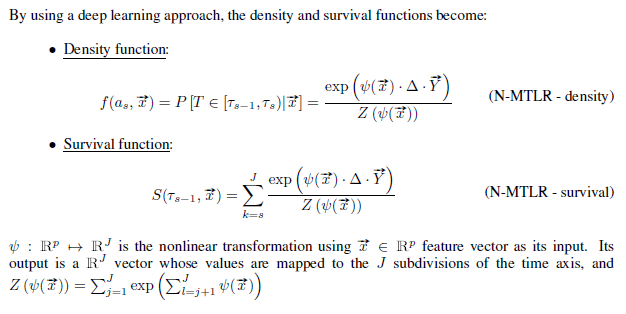





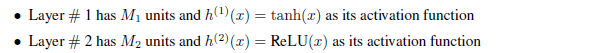


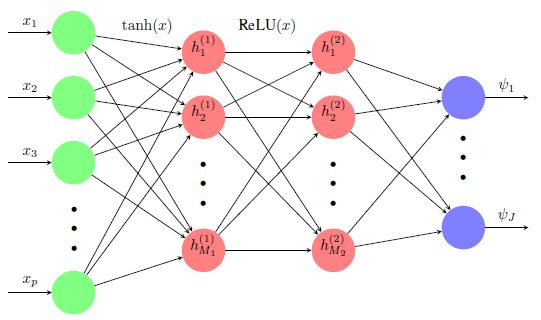

## Fitting and evaluating the model
The model structure is defined. The model is fitted on on our dataset and then evaluated